In [35]:
#adapted from http://mlbernauer.com/R/20160131-document-retrieval-sklearn.html

In [1]:
import os
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.externals import joblib

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from collections import defaultdict

In [2]:
os.getcwd()

'/Users/ptighe/Documents/Python Projects/AcutePainOntology/medline_testing'

In [3]:
path='data/pubmed_mesh_pain_english_4142016.txt'

In [4]:
#Taken directly from reference:

In [4]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
def read_medline_data(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "authors", "affiliation", "grant",
                                   "abstract", "pubdate"])
    count = 0
    for rec in recs:
        try:
            abstr = rec["AB"]
            atitle = rec["TI"]
            auths = rec["AU"]
            pubdate = rec["DP"]
            jtitle = rec["JT"]
            grant=rec["GR"]
            pmid = rec['PMID']
            affil = rec['AD']
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle, auths, affil,grant, abstr,pubdate]],
                                     columns=["pmid", "articletitle", "journaltitle", "authors", "affiliation", 
                                              "grant", "abstract", "pubdate"]),ignore_index=True)            
        except:
            pass
    return text

In [5]:
# Read in MEDLINE formatted text
%time papers = read_medline_data(path)

In [6]:
papers.loc[0,'abstract']

'IMPORTANCE: Mindfulness-based stress reduction (MBSR) has not been rigorously evaluated for young and middle-aged adults with chronic low back pain. OBJECTIVE: To evaluate the effectiveness for chronic low back pain of MBSR vs cognitive behavioral therapy (CBT) or usual care. DESIGN, SETTING, AND PARTICIPANTS: Randomized, interviewer-blind, clinical trial in an integrated health care system in Washington State of 342 adults aged 20 to 70 years with chronic low back pain enrolled between September 2012 and April 2014 and randomly assigned to receive MBSR (n = 116), CBT (n = 113), or usual care (n = 113). INTERVENTIONS: CBT (training to change pain-related thoughts and behaviors) and MBSR (training in mindfulness meditation and yoga) were delivered in 8 weekly 2-hour groups. Usual care included whatever care participants received. MAIN OUTCOMES AND MEASURES: Coprimary outcomes were the percentages of participants with clinically meaningful (>/=30%) improvement from baseline in functiona

In [7]:
#Need to find a list of subheadings to remove? Ideally would remove words/phrases in all caps

shp = re.compile(r'^[A-Z\d]+$')

subheadings =[u"OBJECTIVES:", u"OBJECTIVE:", u"AIMS:", u"OBJECTIVE/BACKGROUND:", u"CONCLUSIONS AND RELEVANCE:", u"TRIAL REGISTRATION:",
              u"METHODS AND RESULTS:", u"CONCLUSIONS:", u"RESULTS:", u"METHODS:", u"INTRODUCTION:", u"BACKGROUND:", ]

In [24]:
#This is broken 
shd = papers['abstract'].str.split().apply(lambda x: x.isupper() = True)

SyntaxError: lambda cannot contain assignment (<ipython-input-24-622cfc9173ae>, line 2)

In [9]:
#Now some items for cleaning the abstract text
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
stoplist.extend(['\x0c', '\n'])
# subheadings =[u"OBJECTIVES:", u"OBJECTIVE:", u"AIMS:", u"OBJECTIVE/BACKGROUND:",
#               u"METHODS AND RESULTS:", u"CONCLUSIONS:", u"RESULTS:", u"METHODS:", u"INTRODUCTION:", u"BACKGROUND:"]

In [10]:
papers['split_abstract'] = papers['abstract'].str.split()
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: [item for item in x if item not in subheadings])
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: ' '.join(x).lower().split())
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: [item for item in x if item not in stoplist])

In [11]:
papers['cleaned_abstract']=papers['split_abstract'].apply(lambda x: ' '.join(x))
papers['cleaned_abstract']=papers['cleaned_abstract'].str.replace("[^a-zA-Z]"," ").str.replace("\s+"," ").str.strip()

In [12]:
papers['cleaned_abstract']

0        importance mindfulness based stress reduction ...
1        study question concordance hip pain radiograph...
2        characterize pain exposure prolift placement i...
3        adult population chronic pain lead loss produc...
4        chronic pain affects nearly one third american...
5        symptomatic knee osteoarthritis oa viewed end ...
6        shoulder pain common causes substantial morbid...
7        although much attention given physical determi...
8        oral cancers often severely painful clinically...
9        pain hypersensitivity site inflammation result...
10       mindfulness meditation reduces pain experiment...
11       study examined whether perioperative regimen p...
12       neuropathic pain debilitating clinical problem...
13       patients left ventricular lv systolic dysfunct...
14       study examined short long term neuroprotective...
15       investigate association pain functional indepe...
16       although pain cognitive deficits widespread de.

In [25]:
papers['split_articletitle'] = papers['articletitle'].str.split()
papers['split_articletitle'] = papers['split_articletitle'].apply(lambda x: ' '.join(x).lower().split())
papers['split_articletitle'] = papers['split_articletitle'].apply(lambda x: [item for item in x if item not in stoplist])
papers['cleaned_articletitle']=papers['split_articletitle'].apply(lambda x: ' '.join(x))
papers['cleaned_articletitle']=papers['cleaned_articletitle'].str.replace("[^a-zA-Z]"," ").str.replace("\s\s+"," ")

In [26]:
papers['cleaned_articletitle']

0        effect mindfulness based stress reduction vs c...
1        association hip pain radiographic evidence hip...
2        pain scores exposure rates polypropylene mesh ...
3        managing chronic pain special populations emph...
4        biopsychosocial approach assessing managing pa...
5          knee pain knee injury knee osteoarthritis work 
6                           shoulder disorders occupation 
7        psychological psychosocial determinants muscul...
8                                neurobiology cancer pain 
9        cd b ly g myeloid cells mediate mechanical inf...
10       mindfulness meditation based pain relief emplo...
11       pregabalin reduces postoperative opioid consum...
12       g a essential epigenetic silencing k channel g...
13       importance angina patients coronary disease he...
14       honokiol treatment neonatal pain prevention co...
15       association pain functional independence older...
16       social disruption alters pain cognition animal.

In [28]:
papers['ca_tokens'] =papers['cleaned_abstract'].map(lambda text: nltk.tokenize.word_tokenize(text))
papers['ra_tokens'] =papers['abstract'].map(lambda text: nltk.tokenize.word_tokenize(text))
papers['ca_tokens']


0        [importance, mindfulness, based, stress, reduc...
1        [study, question, concordance, hip, pain, radi...
2        [characterize, pain, exposure, prolift, placem...
3        [adult, population, chronic, pain, lead, loss,...
4        [chronic, pain, affects, nearly, one, third, a...
5        [symptomatic, knee, osteoarthritis, oa, viewed...
6        [shoulder, pain, common, causes, substantial, ...
7        [although, much, attention, given, physical, d...
8        [oral, cancers, often, severely, painful, clin...
9        [pain, hypersensitivity, site, inflammation, r...
10       [mindfulness, meditation, reduces, pain, exper...
11       [study, examined, whether, perioperative, regi...
12       [neuropathic, pain, debilitating, clinical, pr...
13       [patients, left, ventricular, lv, systolic, dy...
14       [study, examined, short, long, term, neuroprot...
15       [investigate, association, pain, functional, i...
16       [although, pain, cognitive, deficits, widespre.

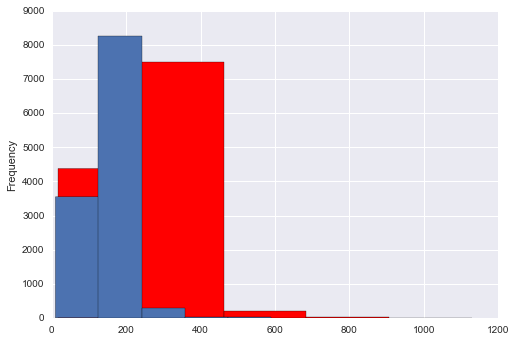

In [29]:
#These give token counts
papers['rabs_length'] =papers['ra_tokens'].map(lambda text: len(text))
papers['cabs_length'] =papers['ca_tokens'].map(lambda text: len(text))
papers.rabs_length.plot(bins=5, kind='hist', color='r')
papers.cabs_length.plot(bins=5, kind='hist')

In [30]:
papers['cabs_u_length'] =papers['ca_tokens'].map(lambda text: len(set(text)))
papers['cabs_u_length']

0        131
1        102
2         67
3         51
4         56
5         59
6         60
7         70
8         35
9        118
10       144
11        95
12        89
13        87
14       105
15        90
16        59
17        90
18       152
19        84
20        79
21       146
22       111
23       107
24       113
25        78
26       102
27       141
28       132
29        73
        ... 
12087    126
12088     90
12089     24
12090     85
12091     96
12092     29
12093     85
12094     63
12095     49
12096     46
12097     58
12098     60
12099     27
12100     55
12101     72
12102     94
12103     88
12104     59
12105     71
12106     84
12107     88
12108     83
12109     41
12110     91
12111     75
12112     69
12113     24
12114     22
12115     92
12116    106
Name: cabs_u_length, dtype: int64

In [31]:
fd = papers['ca_tokens'].map(lambda text: nltk.FreqDist(text))


## Identify the most common terms in the cleaned abstract using the ca_tdm


In [32]:
#Word counts and such using CountVectorizer from https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words

cvec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 100000,\
                              ngram_range=(1,3)) 

In [33]:
train_data_features = cvec.fit_transform(papers['cleaned_abstract'])
train_data_features = train_data_features.toarray()
print ('The nuts of bolts of the CountVectorizer is: ',cvec,'\n')
print ('The shape of the CountVectorizer array is:', train_data_features.shape,'\n')

('The nuts of bolts of the CountVectorizer is: ', CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), '\n')
('The shape of the CountVectorizer array is:', (12117, 100000), '\n')


In [34]:
ca_tdm = pd.DataFrame(cvec.fit_transform(papers.cleaned_abstract).toarray(),columns=cvec.get_feature_names())
ca_tdm

,aa,aa subjects,aa women,aac,aalpha,aalpha beta,aalpha beta neurons,aam,aam years,aas,...,zoster virus vzv,zucker,zung,zygapophyseal,zygapophysial,zygapophysial joint,zygapophysial joint pain,zymosan,zymosan induced,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#Identify the most common terms for each document via CountVectorizer
ca_tdm.idxmax(axis=1) #change to axis=0 will change the document wigh highest countb of each word

0                  mbsr
1                   hip
2              exposure
3               chronic
4                  pain
5                    oa
6              evidence
7                  pain
8                cancer
9                  pain
10           meditation
11           pregabalin
12               injury
13               angina
14             honokiol
15                 pain
16              disease
17                  ome
18            magnesium
19                 pain
20                 mayv
21               camkii
22                fiber
23                 pain
24              ligands
25               opioid
26                 pain
27                   ci
28                 pain
29                  ccr
              ...      
12087       stimulation
12088              nmda
12089              dose
12090              pain
12091          exercise
12092         capsaicin
12093         pregnancy
12094              axis
12095         headaches
12096              pain
12097           

## Plot the most common terms in the cleaned abstract

('Here is a list of the most common terms across all documents: ', '\n', pain                                 62024
patients                             16724
study                                 9807
chronic                               8522
treatment                             6666
associated                            6376
may                                   5822
spinal                                5496
effects                               5346
related                               5044
using                                 4639
significantly                         4634
opioid                                4626
clinical                              4582
group                                 4479
data                                  4470
reported                              4461
significant                           4375
use                                   4336
chronic pain                          4308
studies                               4223
induced                 

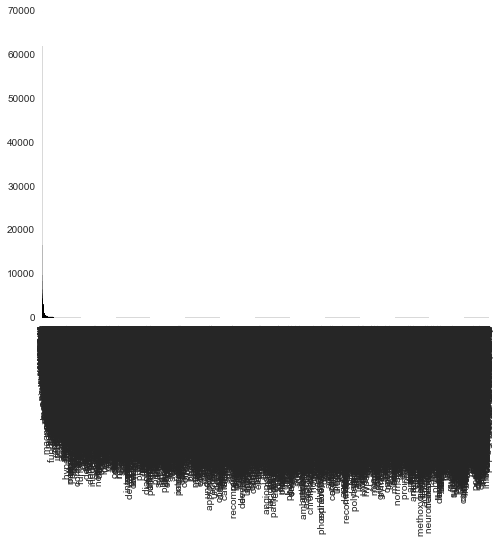

In [36]:
#Identify and visualize the most common terms across all documents
s=ca_tdm.sum().sort_values(ascending=False)
print('Here is a list of the most common terms across all documents: ','\n',s)
s.plot(kind='bar')

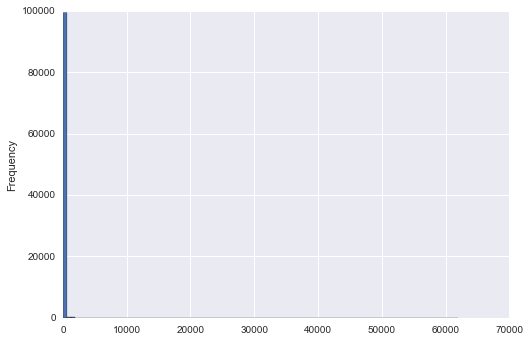

In [37]:
s.plot(kind='hist', bins=100)

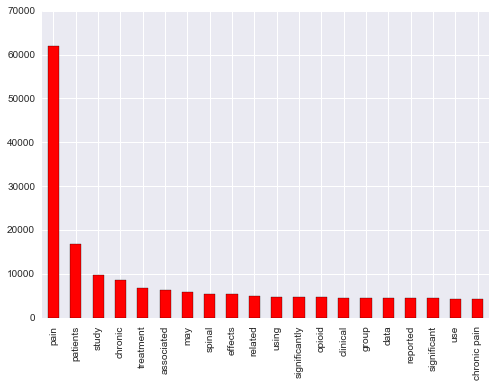

In [38]:
s[0:20].plot(kind='bar', color='r')

### Create TF-IDF for Abstracts

In [39]:
tvec = TfidfVectorizer(analyzer='word',
#                         max_df = 1, min_df=1,
                        max_features=100000,
#                       stopwords='none',
                        use_idf=True,
                        ngram_range=(1,3))

In [40]:
%time ca_tfidfm = tvec.fit_transform(papers['cleaned_abstract'])
print ('Shape of Cleaned Abstract TF-IDF Matrix: ',ca_tfidfm.shape)

CPU times: user 20.5 s, sys: 840 ms, total: 21.4 s
Wall time: 21.5 s
('Shape of Cleaned Abstract TF-IDF Matrix: ', (12117, 100000))


In [41]:
terms = tvec.get_feature_names()
terms[0:9]

[u'aa',
 u'aa subjects',
 u'aa women',
 u'aac',
 u'aalpha',
 u'aalpha beta',
 u'aalpha beta neurons',
 u'aam',
 u'aam years']

Axes(0.125,0.125;0.62x0.775)
[[  1.00000000e+00   8.73978156e-03   3.29707293e-02 ...,   2.09391126e-03
    1.26723751e-02   6.44597707e-03]
 [  8.73978156e-03   1.00000000e+00   1.23875446e-02 ...,   4.88605374e-03
    3.68481799e-04   4.69763419e-03]
 [  3.29707293e-02   1.23875446e-02   1.00000000e+00 ...,   0.00000000e+00
    4.40966545e-02   1.01064147e-02]
 ..., 
 [  2.09391126e-03   4.88605374e-03   0.00000000e+00 ...,   1.00000000e+00
    1.68910842e-03   8.77350559e-03]
 [  1.26723751e-02   3.68481799e-04   4.40966545e-02 ...,   1.68910842e-03
    1.00000000e+00   1.20163377e-01]
 [  6.44597707e-03   4.69763419e-03   1.01064147e-02 ...,   8.77350559e-03
    1.20163377e-01   1.00000000e+00]]


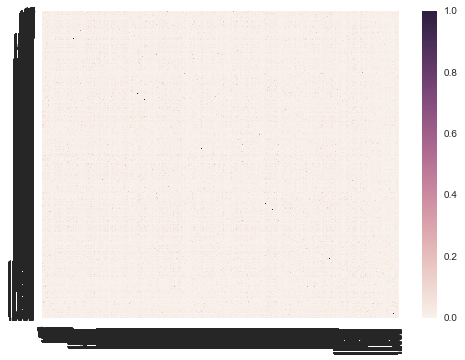

In [42]:
ca_tfidf_cos = cosine_similarity(ca_tfidfm)
print (sns.heatmap(ca_tfidf_cos))
print (ca_tfidf_cos)

## Perform clustering of Abstracts

In [44]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)

%time km.fit(ca_tfidfm)

clusters = km.labels_.tolist()
joblib.dump(km,  'doc_cluster.pkl')

CPU times: user 1min 37s, sys: 2.79 s, total: 1min 40s
Wall time: 26.1 s


['doc_cluster.pkl', 'doc_cluster.pkl_01.npy', 'doc_cluster.pkl_02.npy']

In [ ]:
#joblib.dump(km,  'doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

In [45]:
clusters

[1,
 4,
 4,
 2,
 2,
 4,
 4,
 2,
 2,
 3,
 4,
 4,
 3,
 0,
 3,
 2,
 4,
 3,
 4,
 4,
 4,
 3,
 3,
 4,
 3,
 4,
 4,
 1,
 4,
 3,
 3,
 2,
 2,
 4,
 2,
 2,
 4,
 3,
 3,
 4,
 4,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 1,
 3,
 4,
 3,
 3,
 0,
 3,
 4,
 3,
 4,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 2,
 2,
 3,
 4,
 4,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 3,
 0,
 3,
 2,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 2,
 4,
 4,
 4,
 3,
 4,
 1,
 4,
 4,
 3,
 4,
 4,
 3,
 4,
 0,
 3,
 4,
 4,
 4,
 1,
 2,
 3,
 4,
 4,
 1,
 2,
 4,
 4,
 4,
 3,
 4,
 1,
 3,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 4,
 4,
 4,
 2,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 4,
 4,
 2,
 0,
 4,
 4,
 1,
 3,
 4,
 3,
 2,
 4,
 0,
 4,
 1,
 4,
 3,
 1,
 2,
 3,
 2,
 4,
 4,
 4,
 4,
 2,
 0,
 2,
 3,
 4,
 3,
 4,
 2,
 4,
 2,
 1,
 4,
 4,
 4,
 1,
 2,
 3,
 3,
 1,
 4,
 1,
 2,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 3,
 3,
 1,
 1,
 3,
 3,
 4,
 3,
 1,
 2,
 4,
 3,
 4,
 2,
 4,
 2,
 2,
 4,
 3,


In [46]:
ca_tfidfm

<12117x100000 sparse matrix of type '<type 'numpy.float64'>'
	with 1910044 stored elements in Compressed Sparse Row format>

 *How do we extract the most common terms from each cluster?

## MDS to prepare for cluster visualization

In [47]:
#From http://brandonrose.org/clustering

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(ca_tfidf_cos)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

KeyboardInterrupt: 

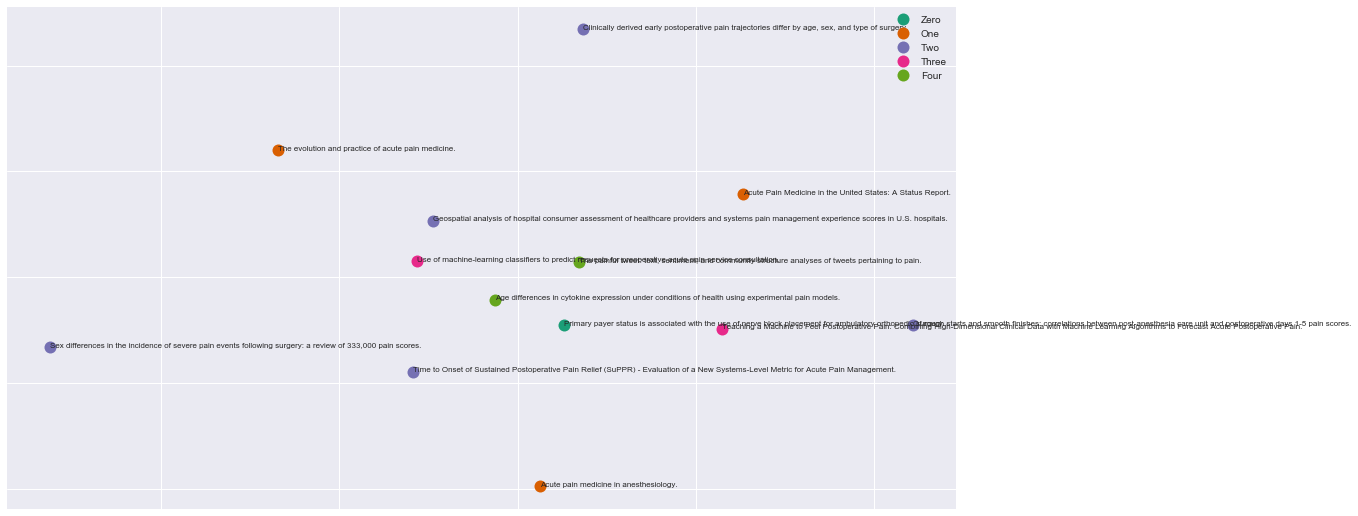

In [71]:
#From http://brandonrose.org/clustering

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict; would be nice to relabel these using common words from each cluster
cluster_names = {0: 'Zero', 
                 1: 'One', 
                 2: 'Two', 
                 3: 'Three', 
                 4: 'Four'}
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# add label in x,y position with the label as the article title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], papers.ix[i]['articletitle'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

array([[  8.        ,  10.        ,   1.15150422,   2.        ],
       [  6.        ,   9.        ,   1.18037873,   2.        ],
       [  0.        ,  13.        ,   1.21670437,   3.        ],
       [  5.        ,  14.        ,   1.2417855 ,   3.        ],
       [  3.        ,  11.        ,   1.26954885,   2.        ],
       [  2.        ,  16.        ,   1.30164942,   4.        ],
       [ 12.        ,  18.        ,   1.35877027,   5.        ],
       [  4.        ,   7.        ,   1.35885919,   2.        ],
       [ 19.        ,  20.        ,   1.37453611,   7.        ],
       [ 17.        ,  21.        ,   1.38151826,   9.        ],
       [  1.        ,  15.        ,   1.38761191,   4.        ],
       [ 22.        ,  23.        ,   1.39608052,  13.        ]])

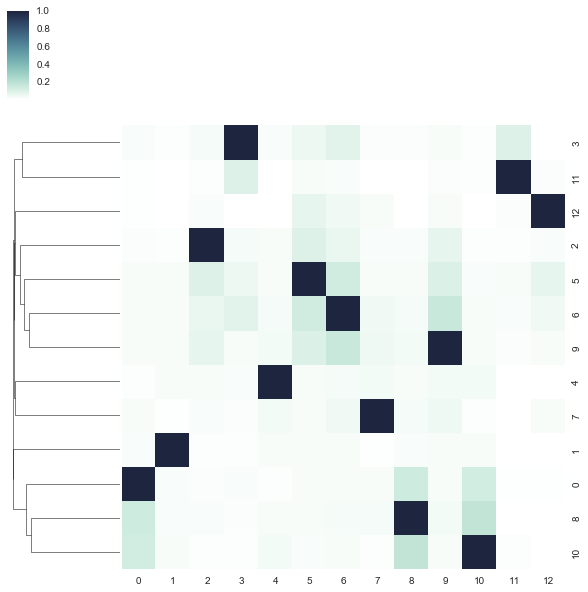

In [81]:
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
sns.clustermap(ca_tfidf_cos, cmap=cmap, col_cluster=False).dendrogram_row.linkage #linkage matrix
# sns.clustermap(ca_tfidf_cos, cmap=cmap, col_cluster=True).dendrogram_col.linkage #linkage matrix for cols if cols True?

### Clustering approach from old ClocksExplore

In [ ]:
#needs to be reviewed in detail

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X_s = X_2pc

range_n_clusters = np.arange(2,11)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1, 1]) 
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_s) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_s)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_s, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_s, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.5)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    #2nd Plot needs to be modified for columns of interest, works best presently for 2-component PCA
    ax2.scatter(X_s[:, 0], X_s[:, 1], marker='.', s=150, lw=0, alpha=0.7,c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()






## GenSim for LDA, Topic Modeling, word2vec

adapted from http://www.datasciencebytes.com/bytes/2014/12/30/topic-modeling-of-shakespeare-characters/

In [83]:
papers[0:3]

,pmid,articletitle,journaltitle,authors,affiliation,grant,abstract,pubdate,split_abstract,cleaned_abstract,split_articletitle,cleaned_articletitle,ca_tokens,ra_tokens,rabs_length,cabs_length,cabs_u_length
0,26535424,Acute Pain Medicine in the United States: A St...,"Pain medicine (Malden, Mass.)","[Tighe P, Buckenmaier CC 3rd, Boezaart AP, Car...","Department of Anesthesiology, University of Fl...","[K23 GM 102697/GM/NIGMS NIH HHS/United States,...",BACKGROUND: Consensus indicates that a compreh...,2015 Sep,"[consensus, indicates, comprehensive,multimoda...",consensus indicates comprehensive multimodal h...,"[acute, pain, medicine, united, states:, statu...",acute pain medicine united states status report,"[consensus, indicates, comprehensive, multimod...","[BACKGROUND, :, Consensus, indicates, that, a,...",277,167,137
1,26456458,Age differences in cytokine expression under c...,Experimental gerontology,"[Cruz-Almeida Y, Aguirre M, Sorenson HL, Tighe...",Pain Research & Intervention Center of Excelle...,"[K01 AG048259/AG/NIA NIH HHS/United States, K0...",Older adults are at an increased risk to devel...,2015 Dec,"[older, adults, increased, risk, develop, freq...",older adults increased risk develop frequent p...,"[age, differences, cytokine, expression, condi...",age differences cytokine expression conditions...,"[older, adults, increased, risk, develop, freq...","[Older, adults, are, at, an, increased, risk, ...",223,129,83
2,26247416,Time to Onset of Sustained Postoperative Pain ...,The Clinical journal of pain,"[Tighe PJ, King CD, Zou B, Fillingim RB]",*Pain Research and Intervention Center of Exce...,[K23 GM102697/GM/NIGMS NIH HHS/United States],OBJECTIVES: Prior work on postoperative pain t...,2015 Aug 5,"[prior, work, postoperative, pain, trajectorie...",prior work postoperative pain trajectories exa...,"[time, onset, sustained, postoperative, pain, ...",time onset sustained postoperative pain relief...,"[prior, work, postoperative, pain, trajectorie...","[OBJECTIVES, :, Prior, work, on, postoperative...",285,142,88


## Topic Modeling via LSI/LDA

In [123]:
abstract_list = papers['ca_tokens'].values
ca_gs_dictionary = corpora.Dictionary(abstract_list)
# once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1]
# ca_gs_dictionary.filter_tokens(once_ids)
# ca_gs_dictionary.compactify()

In [124]:
ca_gs_corpus = [dictionary.doc2bow(words) for words in abstract_list]
# corpora.mmcorpus.MmCorpus.serialize('data/ca_gensim.mm', corpus)
ca_gs_tfidf = models.TfidfModel(ca_gs_corpus)

In [125]:
lsi = models.lsimodel.LsiModel(corpus=tfidf[ca_gs_corpus], id2word=ca_gs_dictionary)
lsi.save('data/ca_gs.lsi')

In [126]:
for i, topic in enumerate(lsi.print_topics(5)[:3]):
    print ('Topic {}:'.format(i))
    print (topic.replace(' + ', '\n'))
    print ()

Topic 0:
0.887*"pain"
0.197*"surgery"
0.177*"acute"
0.105*"using"
0.103*"time"
0.097*"data"
0.096*"apm"
0.080*"well"
0.079*"outcomes"
0.077*"cohort"

Topic 1:
0.802*"surgery"
0.239*"time"
0.190*"data"
-0.180*"pain"
-0.175*"apm"
-0.169*"acute"
0.117*"study"
-0.104*"medicine"
0.103*"recovery"
0.094*"service"

Topic 2:
-0.431*"acute"
-0.382*"apm"
0.219*"pain"
-0.191*"medicine"
-0.176*"regional"
0.172*"older"
-0.169*"patient"
-0.168*"practice"
0.166*"il"
-0.141*"hospital"



In [110]:
matsim = similarities.MatrixSimilarity(lsi[tfidf[ca_gs_corpus]], num_best=6)

In [127]:
%time lda = models.LdaModel(ca_gs_corpus, num_topics=5, id2word =ca_gs_dictionary, update_every=5, passes=100)

CPU times: user 4.72 s, sys: 14 ms, total: 4.74 s
Wall time: 4.75 s


In [128]:
lda.show_topics()

[u'0.048*pain + 0.017*surgery + 0.011*acute + 0.009*ci + 0.009*tweets + 0.009*nrs + 0.008*related + 0.008*terms + 0.008*hour + 0.008*medicine',
 u'0.043*pain + 0.040*scores + 0.022*pods + 0.022*pacu + 0.022*maximum + 0.016*recorded + 0.013*patients + 0.013*median + 0.013*correlation + 0.010*time',
 u'0.020*classifiers + 0.018*pain + 0.016*il + 0.014*older + 0.011*learning + 0.011*machine + 0.011*aps + 0.009*surgical + 0.009*increased + 0.009*using',
 u'0.024*pain + 0.019*apm + 0.016*nerve + 0.015*acute + 0.015*block + 0.013*surgery + 0.010*ambulatory + 0.008*orthopedic + 0.007*patient + 0.007*p',
 u'0.038*pain + 0.027*suppr + 0.018*scores + 0.017*postoperative + 0.012*patients + 0.011*using + 0.011*pod + 0.010*surgery + 0.008*time + 0.008*spe']

In [129]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

['pain', 'surgery', 'acute', 'ci', 'tweets', 'nrs', 'related', 'terms', 'hour', 'medicine', 'postoperative', 'social', 'per', 'patients', 'trajectories', 'included', 'score', 'proportion', 'context', 'content']

['pain', 'scores', 'pods', 'pacu', 'maximum', 'recorded', 'patients', 'median', 'correlation', 'time', 'study', 'hour', 'within', 'period', 'care', 'surgical', 'correlations', 'score', 'single', 'set']

['classifiers', 'pain', 'il', 'older', 'learning', 'machine', 'aps', 'surgical', 'increased', 'using', 'consultation', 'preoperative', 'subjects', 'adults', 'dimensional', 'reduction', 'computational', 'cases', 'request', 'elevations']

['pain', 'apm', 'nerve', 'acute', 'block', 'surgery', 'ambulatory', 'orthopedic', 'patient', 'p', 'clinical', 'primary', 'likelihood', 'perioperative', 'or', 'receiving', 'ci', 'patients', 'data', 'anesthesia']

['pain', 'suppr', 'scores', 'postoperative', 'patients', 'using', 'pod', 'surgery', 'time', 'spe', 'outcomes', 'analyses', 'hours', 'var

## Word2Vec

In [51]:
papers['cleaned_abstract'][0:3]

0    importance mindfulness based stress reduction ...
1    study question concordance hip pain radiograph...
2    characterize pain exposure prolift placement i...
Name: cleaned_abstract, dtype: object

In [67]:
texts_cleaned = filter(None, [next_text.strip(' ').split(' ') for next_text in papers['cleaned_abstract']])
w2vmodel = gensim.models.Word2Vec(texts_cleaned, size=1000, window=5, min_count=5, workers=4)
w2vmodel.save('data/w2v_stemmed_model_4_14_Pain_MESH_cleanedabstracts')

In [68]:
# m = gensim.models.Word2Vec.load("models/pubmed_all_pain(mesh)_human_english_word2vec.mod")
m2 = w2vmodel

In [76]:
# Basic Similarity Testing

print 'Most similar to pain:', m2.most_similar('pain'); print ('')
print 'Most similar to acute:', m2.most_similar('acute'); print ('')
print 'Most similar to chronic:', m2.most_similar('chronic')
print ('')
print ('')
print 'Most similar between pain - chronic:', m2.most_similar(positive=['pain'], negative=['chronic']); print ('')
print 'Most similar between pain - acute:', m2.most_similar(positive=['pain'], negative=['acute']);print ('')
print ('')
print 'Most similar between acute and chronic:', m2.most_similar(positive=['acute'], negative=['chronic']);print ('')
print 'Most similar between chronic and acute:', m2.most_similar(positive=['chronic'], negative=['acute']);print ('')
print ('')
print 'Calculated similarity between acute and chronic:', m2.similarity('acute', 'chronic');print ('')
print 'Calculated similarity between anesthesia and surgery:', m2.similarity('anesthesia', 'surgery');print ('')

Most similar to pain: [('discomfort', 0.4167819023132324), ('attribute', 0.38689127564430237), ('febrile', 0.35664334893226624), ('intensity', 0.35424748063087463), ('sib', 0.3495088815689087), ('subacute', 0.3477737307548523), ('controllability', 0.34771567583084106), ('gagging', 0.3468330204486847), ('emotionality', 0.3451192378997803), ('reported', 0.3443070948123932)]

Most similar to acute: [('noncardiac', 0.5514912605285645), ('electrocardiographic', 0.5369337797164917), ('presenting', 0.5311233401298523), ('chest', 0.5273170471191406), ('acs', 0.5228427648544312), ('suspected', 0.518391489982605), ('ischemia', 0.5167244076728821), ('angiograms', 0.5132092237472534), ('myocardial', 0.5064791440963745), ('recurrent', 0.5043087005615234)]

Most similar to chronic: [('persistent', 0.5354322791099548), ('radicular', 0.5178118348121643), ('nonbacterial', 0.516910970211029), ('subacute', 0.5010874271392822), ('nonmalignant', 0.48205214738845825), ('intractable', 0.4612608551979065), ('

In [77]:
# Create word lists: is there a way to do this for the most common terms from each cluster or topic?
painwordlist = ['pain', 'chronic', 'acute', 'surgery', 'perioperative', 'anesthesia', 'neuropathic', 'visceral',
                'somatic',
                'sympathetic']

analgesicwordlist = ['regional', 'epidural', 'paravertebral', 'nerve', 'block', 'opioid', 'nsaid', 'acetaminophen',
                      'local', 'anesthetic']

x=m2['pain']
x.shape

(1000,)

In [78]:
def getWordVecs(words):
    vecs = []
    for word in words:
        vecs.append(m2[word].reshape(1, 1000))
    vecs = np.concatenate(vecs)
    return np.array(vecs, dtype='float')  # TSNE expects float type values


# From https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis

In [79]:
painwordlist_vecs = getWordVecs(painwordlist)
analgesicwordlist_vecs = getWordVecs(analgesicwordlist)

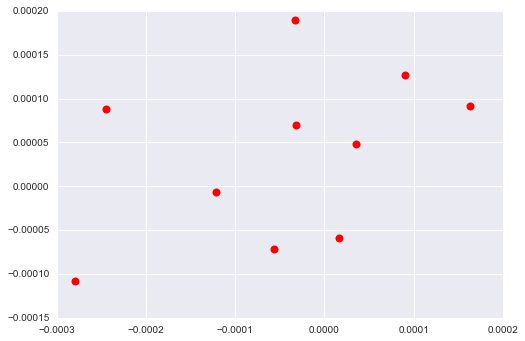

In [80]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#Word Vectors to Consider
vec1 = painwordlist_vecs
vec2 = analgesicwordlist_vecs

ts = TSNE(2)
reduced_vecs = ts.fit_transform(np.concatenate((vec1, vec2)))

#color points by word group to see if Word2Vec can separate them
for i in range(len(vec1)):
    if i <= len(vec2):
        # vec 1 words colored red
        color = 'r'
    else:
        #vec2 words colored blue
        color = 'b'
    plt.plot(reduced_vecs[i,0], reduced_vecs[i,1], marker='o', color=color, markersize=8)